# Transformer for BPMN task recommendation

This file includes data preprocessing, transformer training and evaluation.

In [1]:
##  All imports

import torch
import torch.nn as nn
import torch.optim as optim

import math
import numpy as np
from os import listdir
import matplotlib.pyplot as plt

In [64]:
##  ============  1  ============  ##

##  After running "process_builder.py" encode all processes from "./all_outputs",
##  delete duplicates and write to the "filtered.txt"
def save_unique_processes(write_to_fname: str) -> None:
    def get_process_from_file(fname:str) -> list[int]:
        proc_list = []
        with open(fname) as proc:
            for line in proc.readlines():
                if (l := line.strip()) != "":
                    l_list = l.split(", ")
                    l_list = int(l_list[0]), int(l_list[1]), int(l_list[2])
                    proc_list.append(TaskEncode(l_list))
        return proc_list


    def get_all_unique_processes(dset_fnames: list[str]) -> set[tuple[int]]:
        nonlocal paramdir

        tmp1 = set()
        for f in dset_fnames:
            proc = get_process_from_file(paramdir + f)
            tmp1.add(tuple(proc))
        return tmp1


    paramdir = "./all_outputs/"
    dirlist = listdir(paramdir)
    print("Total:", len(dirlist), "files")
    with open(write_to_fname, 'w') as ffile:
        for proc in get_all_unique_processes(dirlist):
            ffile.write(str(proc) + '\n')
    print("Unique processes saved to", write_to_fname)


##  ============  2  ============  ##

##  Load processes from "filtered.txt"
def get_procs(fname: str) -> list[tuple[int]]:
    proc_list = []
    with open(fname) as procs:
        for line in procs.readlines():
            proc_list.append(eval(line))
    return proc_list


##  ============  3  ============  ##

##  Read options from "unique_params.txt"
def get_options(fname: str) -> tuple[list[str], list[str], list[str]]:
    _URLs: list[str] = []; _TASKTYPEs: list[str] = []; _METHODs: list[str] = []
    tmp:   list[str] = []

    with open(fname) as params:
        for string in params.readlines():
            string = string.strip()
            if string == "URLs:":
                tmp = _URLs
                continue
            if string == "Task types:":
                tmp = _TASKTYPEs
                continue
            if string == "Methods:":
                tmp = _METHODs
                continue
            tmp.append(string)
    return _URLs, _TASKTYPEs, _METHODs


##  ============  4  ============  ##

##  "Encode" (URL index, Task Type index, Method index) to one number - token
def TaskEncode(l_list: tuple[int, int, int]) -> int:
    global URLs, TASKTYPEs
    return l_list[0] + l_list[1] * len(URLs) + l_list[2] * (len(URLs) * len(TASKTYPEs))


##  "Decode" token -> (URL index, Task Type index, Method index)
def TaskDecode(_num: int) -> tuple[int, int, int]:
    global URLs, TASKTYPEs

    url_id = _num % len(URLs)
    met_id = _num // (len(TASKTYPEs) * len(URLs))
    tsk_id = (_num - url_id - met_id * (len(TASKTYPEs) * len(URLs))) // len(URLs)
    return [url_id, tsk_id, met_id]


##  Dataset generator
def DatasetGenWholeProc(dset: list[tuple[int]], batch_size: int, start_from_batch: int = 0):
    def align(lst: list) -> list:
        lst.extend((0 for _ in range(max_seq_length - len(lst))))
        return lst

    tmp1, tmp2, tmp3 = [], [], []
    for proc in dset[batch_size * start_from_batch :]:
        proc = list(proc)

        tmp1.append(align(proc))
        tmp2.append(align(proc[:-1]))
        tmp3.append(align(proc[1:]))

        if len(tmp1) >= batch_size:
            yield torch.tensor(tmp1, dtype=torch.long), torch.tensor(tmp2, dtype=torch.long), torch.tensor(tmp3, dtype=torch.long)
            tmp1, tmp2, tmp3 = [], [], []

    if len(tmp1):
        yield torch.tensor(tmp1, dtype=torch.long), torch.tensor(tmp2, dtype=torch.long), torch.tensor(tmp3, dtype=torch.long)



##  1  ##

if 0: save_unique_processes("./filtered.txt")


##  2  ##

##  "filtered.txt" stores all unique BPMN processes used in training (already shuffled)
procs = get_procs("./filtered.txt")
train, val, test = procs[: int(0.8 * len(procs))], procs[int(0.8 * len(procs)) : int(0.9 * len(procs))], procs[int(0.9 * len(procs)) :]


##  3  ##

URLs, TASKTYPEs, METHODs = get_options("./unique_params.txt")
print("Total:", len(URLs), "URLs,", len(TASKTYPEs), "task types,", len(METHODs), "methods")


##  4  ##

##  Transformer hyperparameters
max_seq_length = 512
num_layers = 6
num_heads = 8
d_model = 512
dropout = 0.1
d_ff = 2048
src_vocab_size = len(URLs) * len(TASKTYPEs) * len(METHODs) + 5
tgt_vocab_size = len(URLs) * len(TASKTYPEs) * len(METHODs) + 5

Total: 285 URLs, 13 task types, 4 methods


Transformer class

In [5]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads

        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask= None):
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask == 0, -1e9)
        attn_probs = torch.softmax(attn_scores, dim=-1)
        output = torch.matmul(attn_probs, V)
        return output
        
    def split_heads(self, x):
        batch_size, seq_length, d_model= x.size()
        return x.view(batch_size, seq_length, self.num_heads, self.d_k).transpose(1, 2)
        
    def combine_heads(self, x):
        batch_size, _, seq_length, d_k= x.size()
        return x.transpose(1, 2).contiguous().view(batch_size, seq_length, self.d_model)
        
    def forward(self, Q, K, V, mask= None):
        Q = self.split_heads(self.W_q(Q))
        K = self.split_heads(self.W_k(K))
        V = self.split_heads(self.W_v(V))
        
        attn_output = self.scaled_dot_product_attention(Q, K, V, mask)
        output = self.W_o(self.combine_heads(attn_output))
        return output


class PositionWiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super(PositionWiseFeedForward, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))


class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length):
        super(PositionalEncoding, self).__init__()
        
        pe = torch.zeros(max_seq_length, d_model)
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        self.register_buffer('pe', pe.unsqueeze(0))
        
    def forward(self, x):
        return x + self.pe[:, :x.size(1)]


class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, mask):
        attn_output = self.self_attn(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))
        return x


class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.cross_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, enc_output, src_mask, tgt_mask):
        attn_output = self.self_attn(x, x, x, tgt_mask)
        x = self.norm1(x + self.dropout(attn_output))
        attn_output = self.cross_attn(x, enc_output, enc_output, src_mask)
        x = self.norm2(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm3(x + self.dropout(ff_output))
        return x


class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout):
        super(Transformer, self).__init__()
        self.encoder_embedding = nn.Embedding(src_vocab_size, d_model)
        self.decoder_embedding = nn.Embedding(tgt_vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_seq_length)

        self.encoder_layers = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.decoder_layers = nn.ModuleList([DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])

        self.fc = nn.Linear(d_model, tgt_vocab_size)
        self.dropout = nn.Dropout(dropout)

    def generate_mask(self, src, tgt):
        src_mask = (src != 0).unsqueeze(1).unsqueeze(2)
        tgt_mask = (tgt != 0).unsqueeze(1).unsqueeze(3)
        seq_length = tgt.size(1)
        nopeak_mask = (1 - torch.triu(torch.ones(1, seq_length, seq_length), diagonal=1)).bool()
        tgt_mask = tgt_mask & nopeak_mask
        return src_mask, tgt_mask

    def forward(self, src, tgt):
        src_mask, tgt_mask = self.generate_mask(src, tgt)
        src_embedded = self.dropout(self.positional_encoding(self.encoder_embedding(src)))
        tgt_embedded = self.dropout(self.positional_encoding(self.decoder_embedding(tgt)))

        enc_output = src_embedded
        for enc_layer in self.encoder_layers:
            enc_output = enc_layer(enc_output, src_mask)

        dec_output = tgt_embedded
        for dec_layer in self.decoder_layers:
            dec_output = dec_layer(dec_output, enc_output, src_mask, tgt_mask)

        output = self.fc(dec_output)
        return output

* Transformer: create a new object or load pre-trained model
* Cross-entropy loss
* ADAM optimizer

In [6]:
pretrained = True

if not pretrained: tformer = Transformer(src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout)
if     pretrained: tformer : Transformer = torch.load("./tformer_last.ckpt")

criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(tformer.parameters(), lr= 1e-4, betas= (0.9, 0.98), eps= 1e-9)

Training + validation

In [7]:
##  Training + validation every "val_every" batches (for "val_num_batches" batches)

def training(tformer: Transformer, num_epochs: int, batch_size: int, from_batch: int, val_dset_gen, val_num_batches: int) -> None:
    # global tgt_vocab_size, criterion, optimizer

    tformer.train()
    print("Total number of trainable parameters =", sum((p.numel() for p in tformer.parameters() if p.requires_grad)))

    for epoch in range(num_epochs):
        i = from_batch
        for source, t_target, l_target in DatasetGenWholeProc(train, batch_size, from_batch):
            optimizer.zero_grad()

            output = tformer(source, t_target)

            loss = criterion(output.contiguous().view(-1, tgt_vocab_size), l_target.contiguous().view(-1))
            loss.backward()

            optimizer.step()

            print("Iteration", i, f": loss = {loss.item()}", end= '\r')
            if i and not i % val_every:
                print()
                validation(tformer, val_dset_gen, val_num_batches)
                print()
                tformer.train()
            i += 1


def validation(tformer: Transformer, val_dset_gen, num_batches: int) -> None:
    def get_topk_acc(_output: torch.Tensor, _target, k: list) -> list[int]:
        tokens = np.argsort(_output.numpy(), 2)[:, :, -k[0]:]
        s1 = [0 for _ in range(len(k))]

        for n_elem in range(tokens.shape[0]):
            s2 = [0 for _ in range(len(k))]

            x = list(tokens[n_elem])
            labels = _target[n_elem].tolist()

            for l in range(max_seq_length):
                if not labels[l]:
                    for j in range(len(k)):
                        s1[j] += s2[j] / l
                    break

                for j in range(len(k)):
                    s2[j] += labels[l] in x[l][-k[j]:]

        for j in range(len(k)):
            s1[j] /= tokens.shape[0]
        return s1


    tformer.eval()
    topk_accs = (5, 3, 1)

    with torch.no_grad():
        i, acc = 0, [0, 0, 0]
        for source, t_target, l_target in val_dset_gen:
            optimizer.zero_grad()

            output = tformer(source, t_target)
            tmp = get_topk_acc(output, l_target, topk_accs)

            for j in range(len(topk_accs)):
                acc[j] += tmp[j]
            if (i := i + 1) == num_batches: break
            print(f"Validation iter {i}: top-1 = {acc[2] / max(i, 1):1.7}, top-3 = {acc[1] / max(i, 1):1.7}, top-5 = {acc[0] / max(i, 1):1.7}", end= '\r')


## Training + validation

val_every = 40
val_num_batches = 20
val_gen = DatasetGenWholeProc(val, 4)

train_from_batch = 0
train_batch_size = 4
train_num_epochs = 1

do_train = False
if do_train: training(tformer, train_num_epochs, train_batch_size, train_from_batch, val_gen, val_num_batches)

Checkpoint save

In [8]:
save_checkpoint = False
if save_checkpoint: torch.save(tformer, "./tformer_checkpoint.ckpt")

Print top-5 for test dataset

In [11]:
def get_top_k(tformer: Transformer, val_gen, num_batches: int, k = 5):
    def TaskBatchDecode(_num: np.ndarray):
        # global URLs, TASKTYPEs

        url_id = _num % len(URLs)
        met_id = _num // (len(TASKTYPEs) * len(URLs))
        tsk_id = (_num - url_id - met_id * (len(TASKTYPEs) * len(URLs))) // len(URLs)
        return np.stack([url_id, tsk_id, met_id], 3)


    def get_topk(_output: torch.Tensor, k = 5):
        batch = np.argsort(_output.numpy(), 2)[:, :, -k:]
        return TaskBatchDecode(batch[..., ::-1])


    tformer.eval()
    with torch.no_grad():
        i = 0
        for source, t_target, l_target in val_gen:
            output = tformer(source, t_target)
            tmp = get_topk(output, k)
            print(f"Predictions {i}: top-{k} = {tmp.tolist()[0]}", end= '\r')
            if (i := i + 1) == num_batches: break


if 0: get_top_k(tformer, DatasetGenWholeProc(test, 4), 1)

KeyboardInterrupt: 

Top-5 for validation dataset

In [12]:
if 0: get_top_k(tformer, DatasetGenWholeProc(val, 4), 1000)

KeyboardInterrupt: 

## Transformer prediction checks

Validation + task checks

In [24]:
def validation_check(tformer : Transformer, val_gen, num_batches: int, last_k = 5):
    global S0, S1, SAll

    def get_topk_acc(_output: torch.Tensor, _target, k: list):
        tokens = np.argsort(_output.numpy(), 2)[:, :, -k[0]:]
        s1 = [0 for _ in range(len(k))]
        for n_elem in range(tokens.shape[0]):
            s2 = [0 for _ in range(len(k))]

            x = list(tokens[n_elem])
            labels = _target[n_elem].tolist()
            for l in range(max_seq_length):
                if not labels[l]:
                    for j in range(len(k)):
                        s1[j] += s2[j] / l
                    break

                if labels[l] in x[l][-last_k:]:
                    S1.add(labels[l])
                else:
                    S0.add(labels[l])

                for j in range(len(k)):
                    s2[j] += labels[l] in x[l][-k[j]:]

        for j in range(len(k)):
            s1[j] /= tokens.shape[0]
        return s1


    tformer.eval()
    topk_accs = (5, 3, 1)
    with torch.no_grad():
        i, acc = 0, [0, 0, 0]
        for source, t_target, l_target in val_gen:
            output = tformer(source, t_target)
            tmp = get_topk_acc(output, l_target, topk_accs)
            for j in range(len(topk_accs)):
                acc[j] += tmp[j]
            if (i := i + 1) == num_batches: break
            print(f"Check iteration {i}", end= '\r')
        l1 = len(S1.union(S0))
        print('\n', len(S1) / l1, len(S0) / l1)
        print(len(S0.intersection(S1)) / len(S0))



S0, S1, SAll = set(), set(), set()
validation_check(tformer, DatasetGenWholeProc(test, 4), 1000)

Check iteration 203
 0.8164556962025317 0.3227848101265823
0.43137254901960786


In [25]:
validation_check(tformer, DatasetGenWholeProc( val, 4), 1000)

Check iteration 203
 0.7103825136612022 0.453551912568306
0.3614457831325301


Counts for all tokens

In [26]:
def bow(datasets):
    info = { i : [0 for _ in range(len(datasets))] for i in range(src_vocab_size) }
    for ind, dset in enumerate(datasets):
        for proc in dset:
            for token in proc:
                info[token][ind] += 1
    return info


info = bow((train, val, test))
used_tokens = [ token for token in info if sum(info[token]) ]

In [27]:
def bow2(datasets):
    info_set = set()
    for dset in datasets:
        for proc in dset:
            info_set.update(proc)
    return info_set

info_set = bow2((train, val, test))

In [48]:
print(f"Total number of processes: {len(procs)}")
print(f"Total number of tasks: {len(info_set)}")
print(f"Number of predicted tasks (top-5): {len(S1)}")
print(f"Number of tasks that were not predicted (top-5): {len(S0)}")
print(f"Number of tasks that were always predicted correctly (top-5): {len(S1.difference(S0))}")
print(f"Number of tasks that were never  predicted correctly (top-5): {len(S0.difference(S1))}")

Total number of processes: 8086
Total number of tasks: 215
Number of predicted tasks (top-5): 130
Number of tasks that were not predicted (top-5): 83
Number of tasks that were always predicted correctly (top-5): 100
Number of tasks that were never  predicted correctly (top-5): 53


In [31]:
only1  = [i for i in info if ((info[i][0] != 0) and not (info[i][1] + info[i][2]))]
only2  = [i for i in info if ((info[i][1] != 0) and not (info[i][0] + info[i][2]))]
only3  = [i for i in info if ((info[i][2] != 0) and not (info[i][1] + info[i][0]))]
only12 = [i for i in info if ((info[i][2] == 0) and (info[i][0] + info[i][1]))]
only13 = [i for i in info if ((info[i][1] == 0) and (info[i][0] + info[i][2]))]
only23 = [i for i in info if ((info[i][0] == 0) and (info[i][1] + info[i][2]))]

In [53]:
print(f"Number of tasks that only appear in training dataset: {len(only1)}")
print(f"Number of tasks that only appear in validation dataset: {len(only2)}")
print(f"Number of tasks that only appear in test dataset: {len(only3)}")
print(f"Tasks only in test + val dataset: {len(only23)}")
len(only12), len(only23), len(only13)

Number of tasks that only appear in training dataset: 31
Number of tasks that only appear in validation dataset: 6
Number of tasks that only appear in test dataset: 0
Tasks only in test + val dataset: 6


In [35]:
info_bar = np.array([ [token, (_info[0] + _info[1] + _info[2])] for token, _info in info.items() if (_info[0] + _info[1] + _info[2]) ])
counts = sorted(info_bar[:, 1])
np.array(counts)

array([     1,      1,      1,      1,      1,      1,      1,      1,
            1,      1,      1,      1,      1,      1,      1,      1,
            1,      1,      1,      1,      1,      1,      1,      1,
            1,      1,      1,      2,      2,      2,      3,      3,
            3,      3,      3,      4,      4,      4,      4,      4,
            4,      4,      4,      5,      5,      5,      5,      6,
            6,      6,      6,      6,      6,      6,      6,      6,
            6,      6,      6,      6,      7,      7,      8,      8,
            9,      9,      9,      9,      9,      9,      9,     10,
           10,     10,     10,     10,     10,     10,     10,     12,
           12,     13,     13,     13,     13,     14,     14,     16,
           16,     18,     23,     26,     35,     36,     44,     64,
           88,     88,     96,    113,    128,    144,    144,    150,
          190,    190,    192,    192,    204,    212,    276,    292,
      

In [62]:
cl0 = np.array([[token, sum(_cnts)] for token, _cnts in info.items() if token in S0.difference(S1)])
print("Counts of tasks that were never predicted correctly:\n", cl0[:, 1].tolist())
print("Max:", cl0[:, 1].max())

Counts of tasks that were never predicted correctly:
 [7, 5, 4, 4, 9, 9, 3, 3, 3, 1, 10, 10, 10, 10, 6, 23, 10, 6, 6, 6, 10, 6, 6, 6, 6, 6, 6, 2, 1, 14, 5, 4, 4, 1, 1, 9, 9, 3, 3, 12, 13, 13, 10, 16, 7, 13, 6, 1, 14, 6, 12, 8, 4]
Max: 23


In [63]:
used_urls = set()

for proc in procs:
    for token in proc:
        used_urls.add(token % len(URLs))
        if len(used_urls) == len(URLs): break

len(used_urls)

200

[]

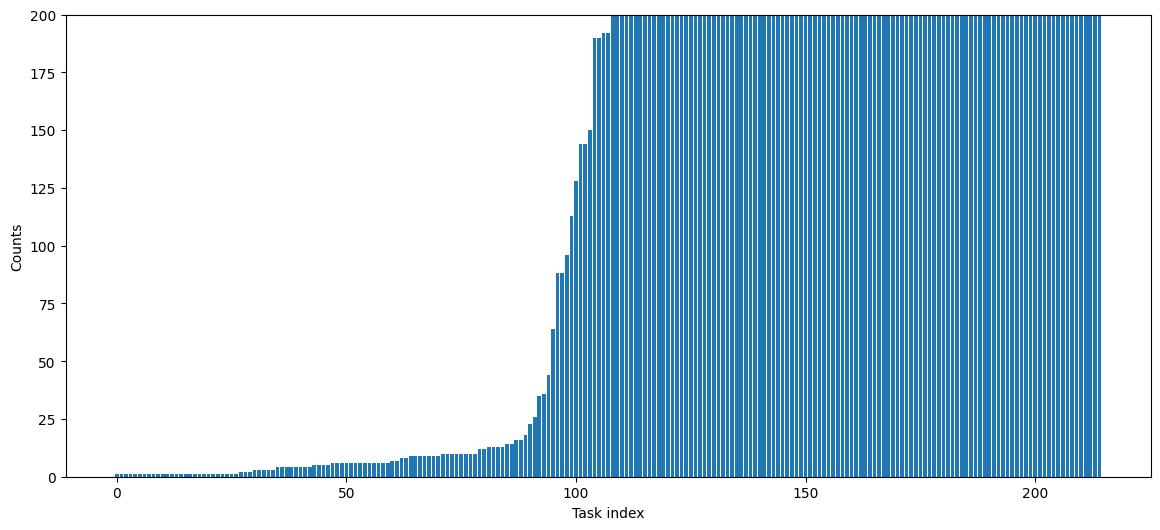

In [40]:
fig, ax = plt.subplots(figsize=(14, 6))
ax.set_ylim(0, 200)
ax.set_xlabel("Task index")
ax.set_ylabel("Counts")
ax.bar([i for i in range(info_bar.shape[0])], counts)
ax.plot()